## Exploratory Data Analysis

In [1]:
#pip install plotnine

In [2]:
import os
import pathlib
import random
import re
from glob import glob
from PIL import Image
from typing import Iterable

import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import image
from plotnine import *


pd.set_option("max_colwidth", None)
plt.style.use("dark_background")

In [3]:
SEED = 3352024

os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)

### Data Loading

In [4]:
DATASET_DIR = "D:/Data" # Please remove your original data set path that has 7 body parts

In [5]:
def inspect_df(df: pd.DataFrame, n: int = 5) -> pd.DataFrame:
    """Helper method to easily inspect DataFrames."""

    print(f"shape: {df.shape}")

    return df.head(n)

In [6]:
random.choices(glob(os.path.join(DATASET_DIR, "*", "*", "*", "*", "*.png")), k=10)

['D:/Data\\train\\XR_WRIST\\patient07453\\study1_negative\\image7.png',
 'D:/Data\\train\\XR_ELBOW\\patient06287\\study1_negative\\image3.png',
 'D:/Data\\train\\XR_HAND\\patient10441\\study1_negative\\image3.png',
 'D:/Data\\train\\XR_SHOULDER\\patient02586\\study1_negative\\image2.png',
 'D:/Data\\train\\XR_ELBOW\\patient05192\\study1_positive\\image2.png',
 'D:/Data\\train\\XR_WRIST\\patient02012\\study1_negative\\image1.png',
 'D:/Data\\train\\XR_ELBOW\\patient06344\\study1_negative\\image3.png',
 'D:/Data\\train\\XR_SHOULDER\\patient00702\\study1_positive\\image1.png',
 'D:/Data\\train\\XR_HUMERUS\\patient03004\\study1_negative\\image1.png',
 'D:/Data\\train\\XR_FINGER\\patient04287\\study1_negative\\image1.png']

So, the data structure is the following:

```

└─train {data subset}
│   └───XR_ELBOW {study type}
│       │  └───patient00011 {patient}
│       │         └───study1_negative {study with label}
│       │               └───image1.png {view}
│       │               └───image2.png 
│       │               └───image3.png 
                        └───...
   ...
   

└─valid {data subset}
│   └───XR_HUMERUS {study type}
│       │  └───patient11216 {patient}
│       │         └───study1_negative {study with label}
│       │               └───image1.png {view}
│       │               └───image2.png 
                        └───...
```

In [7]:
image_count = len(list(pathlib.Path(DATASET_DIR).glob("*/*/*/*/*.png")))

print(f"Total PNG images found in dir <{DATASET_DIR}>: {image_count}")

Total PNG images found in dir <D:/Data>: 40009


We will start by creating a tabular form of the training data (with no actual image files), in order to quickly analyze them. A proper data loader (of the actual image files) will be implemented after that, in a tensorflow-friendly manner.

In [8]:
train_image_paths = pd.read_csv(
    os.path.join(DATASET_DIR, "train_image_paths.csv"),
    names=["image_path"],
    header=None,
    index_col=False,
)

inspect_df(train_image_paths)

shape: (36808, 1)


,image_path
0,D:/Data/train/XR_SHOULDER/patient00001/study1_positive/image1.png
1,D:/Data/train/XR_SHOULDER/patient00001/study1_positive/image2.png
2,D:/Data/train/XR_SHOULDER/patient00001/study1_positive/image3.png
3,D:/Data/train/XR_SHOULDER/patient00002/study1_positive/image1.png
4,D:/Data/train/XR_SHOULDER/patient00002/study1_positive/image2.png


In [9]:
train_image_paths["image_path"] = train_image_paths["image_path"].map(
    lambda x: os.path.join("D:/", x)
)
train_image_paths["study_type"] = train_image_paths["image_path"].map(
    lambda x: x.split("/")[3]
)
train_image_paths["patient"] = train_image_paths["image_path"].map(
    lambda x: x.split("/")[4]
)
train_image_paths["study"] = train_image_paths["image_path"].map(
    lambda x: x.split("/")[5]
)
train_image_paths["study_path"] = train_image_paths["image_path"].map(
    lambda x: re.sub(r"image\d+.png", "", x)
)

In [10]:
inspect_df(train_image_paths)

shape: (36808, 5)


,image_path,study_type,patient,study,study_path
0,D:/Data/train/XR_SHOULDER/patient00001/study1_positive/image1.png,XR_SHOULDER,patient00001,study1_positive,D:/Data/train/XR_SHOULDER/patient00001/study1_positive/
1,D:/Data/train/XR_SHOULDER/patient00001/study1_positive/image2.png,XR_SHOULDER,patient00001,study1_positive,D:/Data/train/XR_SHOULDER/patient00001/study1_positive/
2,D:/Data/train/XR_SHOULDER/patient00001/study1_positive/image3.png,XR_SHOULDER,patient00001,study1_positive,D:/Data/train/XR_SHOULDER/patient00001/study1_positive/
3,D:/Data/train/XR_SHOULDER/patient00002/study1_positive/image1.png,XR_SHOULDER,patient00002,study1_positive,D:/Data/train/XR_SHOULDER/patient00002/study1_positive/
4,D:/Data/train/XR_SHOULDER/patient00002/study1_positive/image2.png,XR_SHOULDER,patient00002,study1_positive,D:/Data/train/XR_SHOULDER/patient00002/study1_positive/


In [11]:
train_labeled_studies = pd.read_csv(
    os.path.join(DATASET_DIR, "train_labeled_studies.csv"),
    names=["study_path", "label"],
    header=None,
    index_col=False,
)

inspect_df(train_labeled_studies)

shape: (13457, 2)


,study_path,label
0,D:/Data/train/XR_SHOULDER/patient00001/study1_positive/,1
1,D:/Data/train/XR_SHOULDER/patient00002/study1_positive/,1
2,D:/Data/train/XR_SHOULDER/patient00003/study1_positive/,1
3,D:/Data/train/XR_SHOULDER/patient00004/study1_positive/,1
4,D:/Data/train/XR_SHOULDER/patient00005/study1_positive/,1


In [12]:
train_labeled_studies["study_path"] = train_labeled_studies["study_path"].map(
    lambda x: os.path.join("D:/", x)
)
train_labeled_studies["label"] = train_labeled_studies["label"].map(str)

In [13]:
inspect_df(train_labeled_studies)

shape: (13457, 2)


,study_path,label
0,D:/Data/train/XR_SHOULDER/patient00001/study1_positive/,1
1,D:/Data/train/XR_SHOULDER/patient00002/study1_positive/,1
2,D:/Data/train/XR_SHOULDER/patient00003/study1_positive/,1
3,D:/Data/train/XR_SHOULDER/patient00004/study1_positive/,1
4,D:/Data/train/XR_SHOULDER/patient00005/study1_positive/,1


In [14]:
ref_trainset = pd.merge(
    train_image_paths, train_labeled_studies, how="inner", on="study_path"
)

inspect_df(ref_trainset)

shape: (36808, 6)


,image_path,study_type,patient,study,study_path,label
0,D:/Data/train/XR_SHOULDER/patient00001/study1_positive/image1.png,XR_SHOULDER,patient00001,study1_positive,D:/Data/train/XR_SHOULDER/patient00001/study1_positive/,1
1,D:/Data/train/XR_SHOULDER/patient00001/study1_positive/image2.png,XR_SHOULDER,patient00001,study1_positive,D:/Data/train/XR_SHOULDER/patient00001/study1_positive/,1
2,D:/Data/train/XR_SHOULDER/patient00001/study1_positive/image3.png,XR_SHOULDER,patient00001,study1_positive,D:/Data/train/XR_SHOULDER/patient00001/study1_positive/,1
3,D:/Data/train/XR_SHOULDER/patient00002/study1_positive/image1.png,XR_SHOULDER,patient00002,study1_positive,D:/Data/train/XR_SHOULDER/patient00002/study1_positive/,1
4,D:/Data/train/XR_SHOULDER/patient00002/study1_positive/image2.png,XR_SHOULDER,patient00002,study1_positive,D:/Data/train/XR_SHOULDER/patient00002/study1_positive/,1


### Exploratory Data Analysis

Each study contains one or more views (images) and is labeled as either normal or abnormal.

The training dataset consists of `13457` studies with a total of `36808` images.

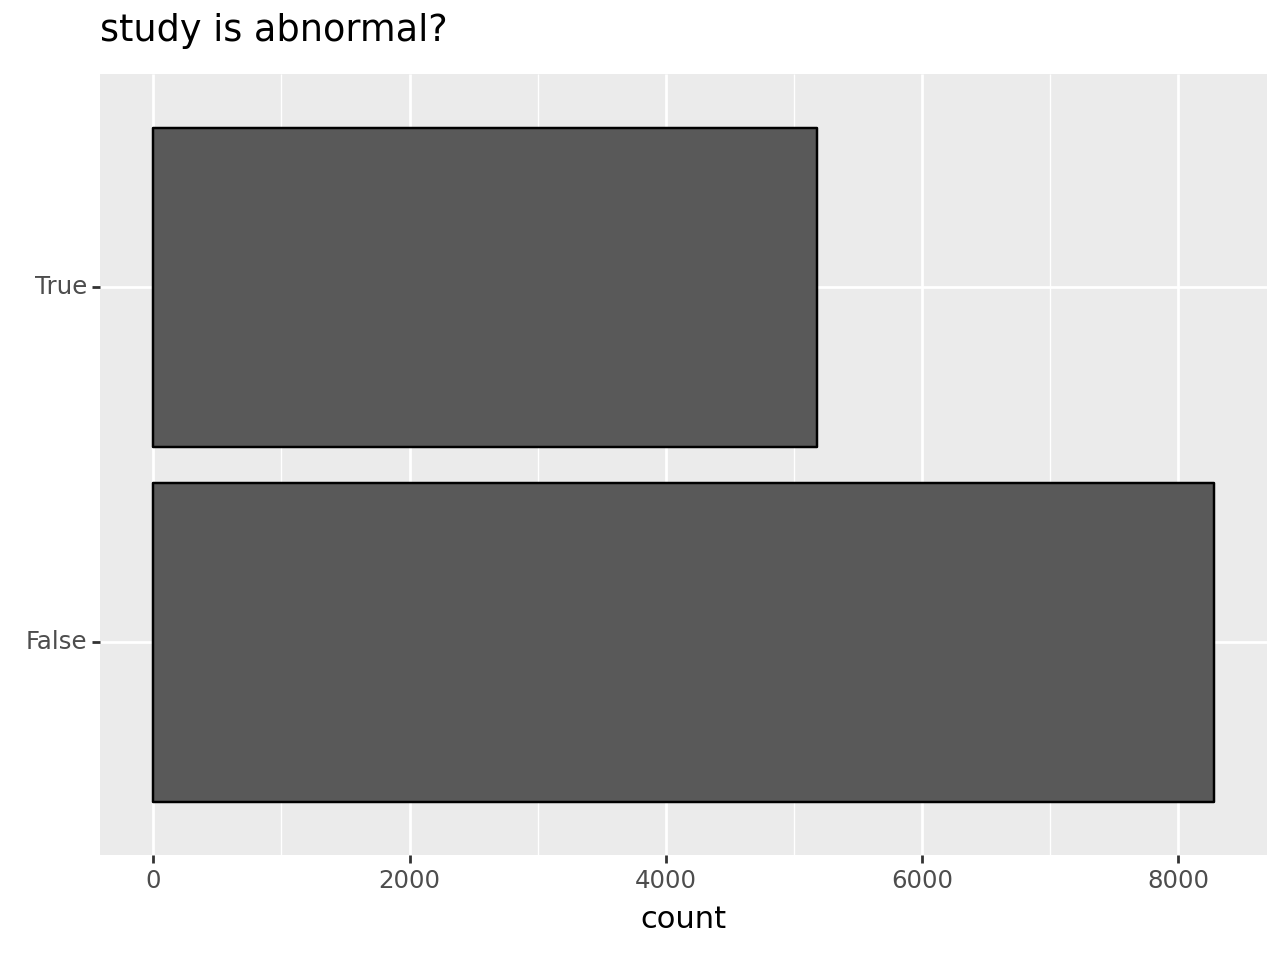

<Figure Size: (640 x 480)>

In [15]:
abnormal = train_labeled_studies["label"] == "1"

(
    ggplot()
    + geom_bar(mapping=aes(x=abnormal), colour="black")
    + labs(title="study is abnormal?", x="")
    + coord_flip()
)

In [16]:
majority_class_size, minority_class_size = abnormal.value_counts().values
imbalance_ratio = round(minority_class_size / majority_class_size, 3)

print(
    f"The imbalance ratio (minority class size / majority class size) is: {imbalance_ratio}"
)

The imbalance ratio (minority class size / majority class size) is: 0.625


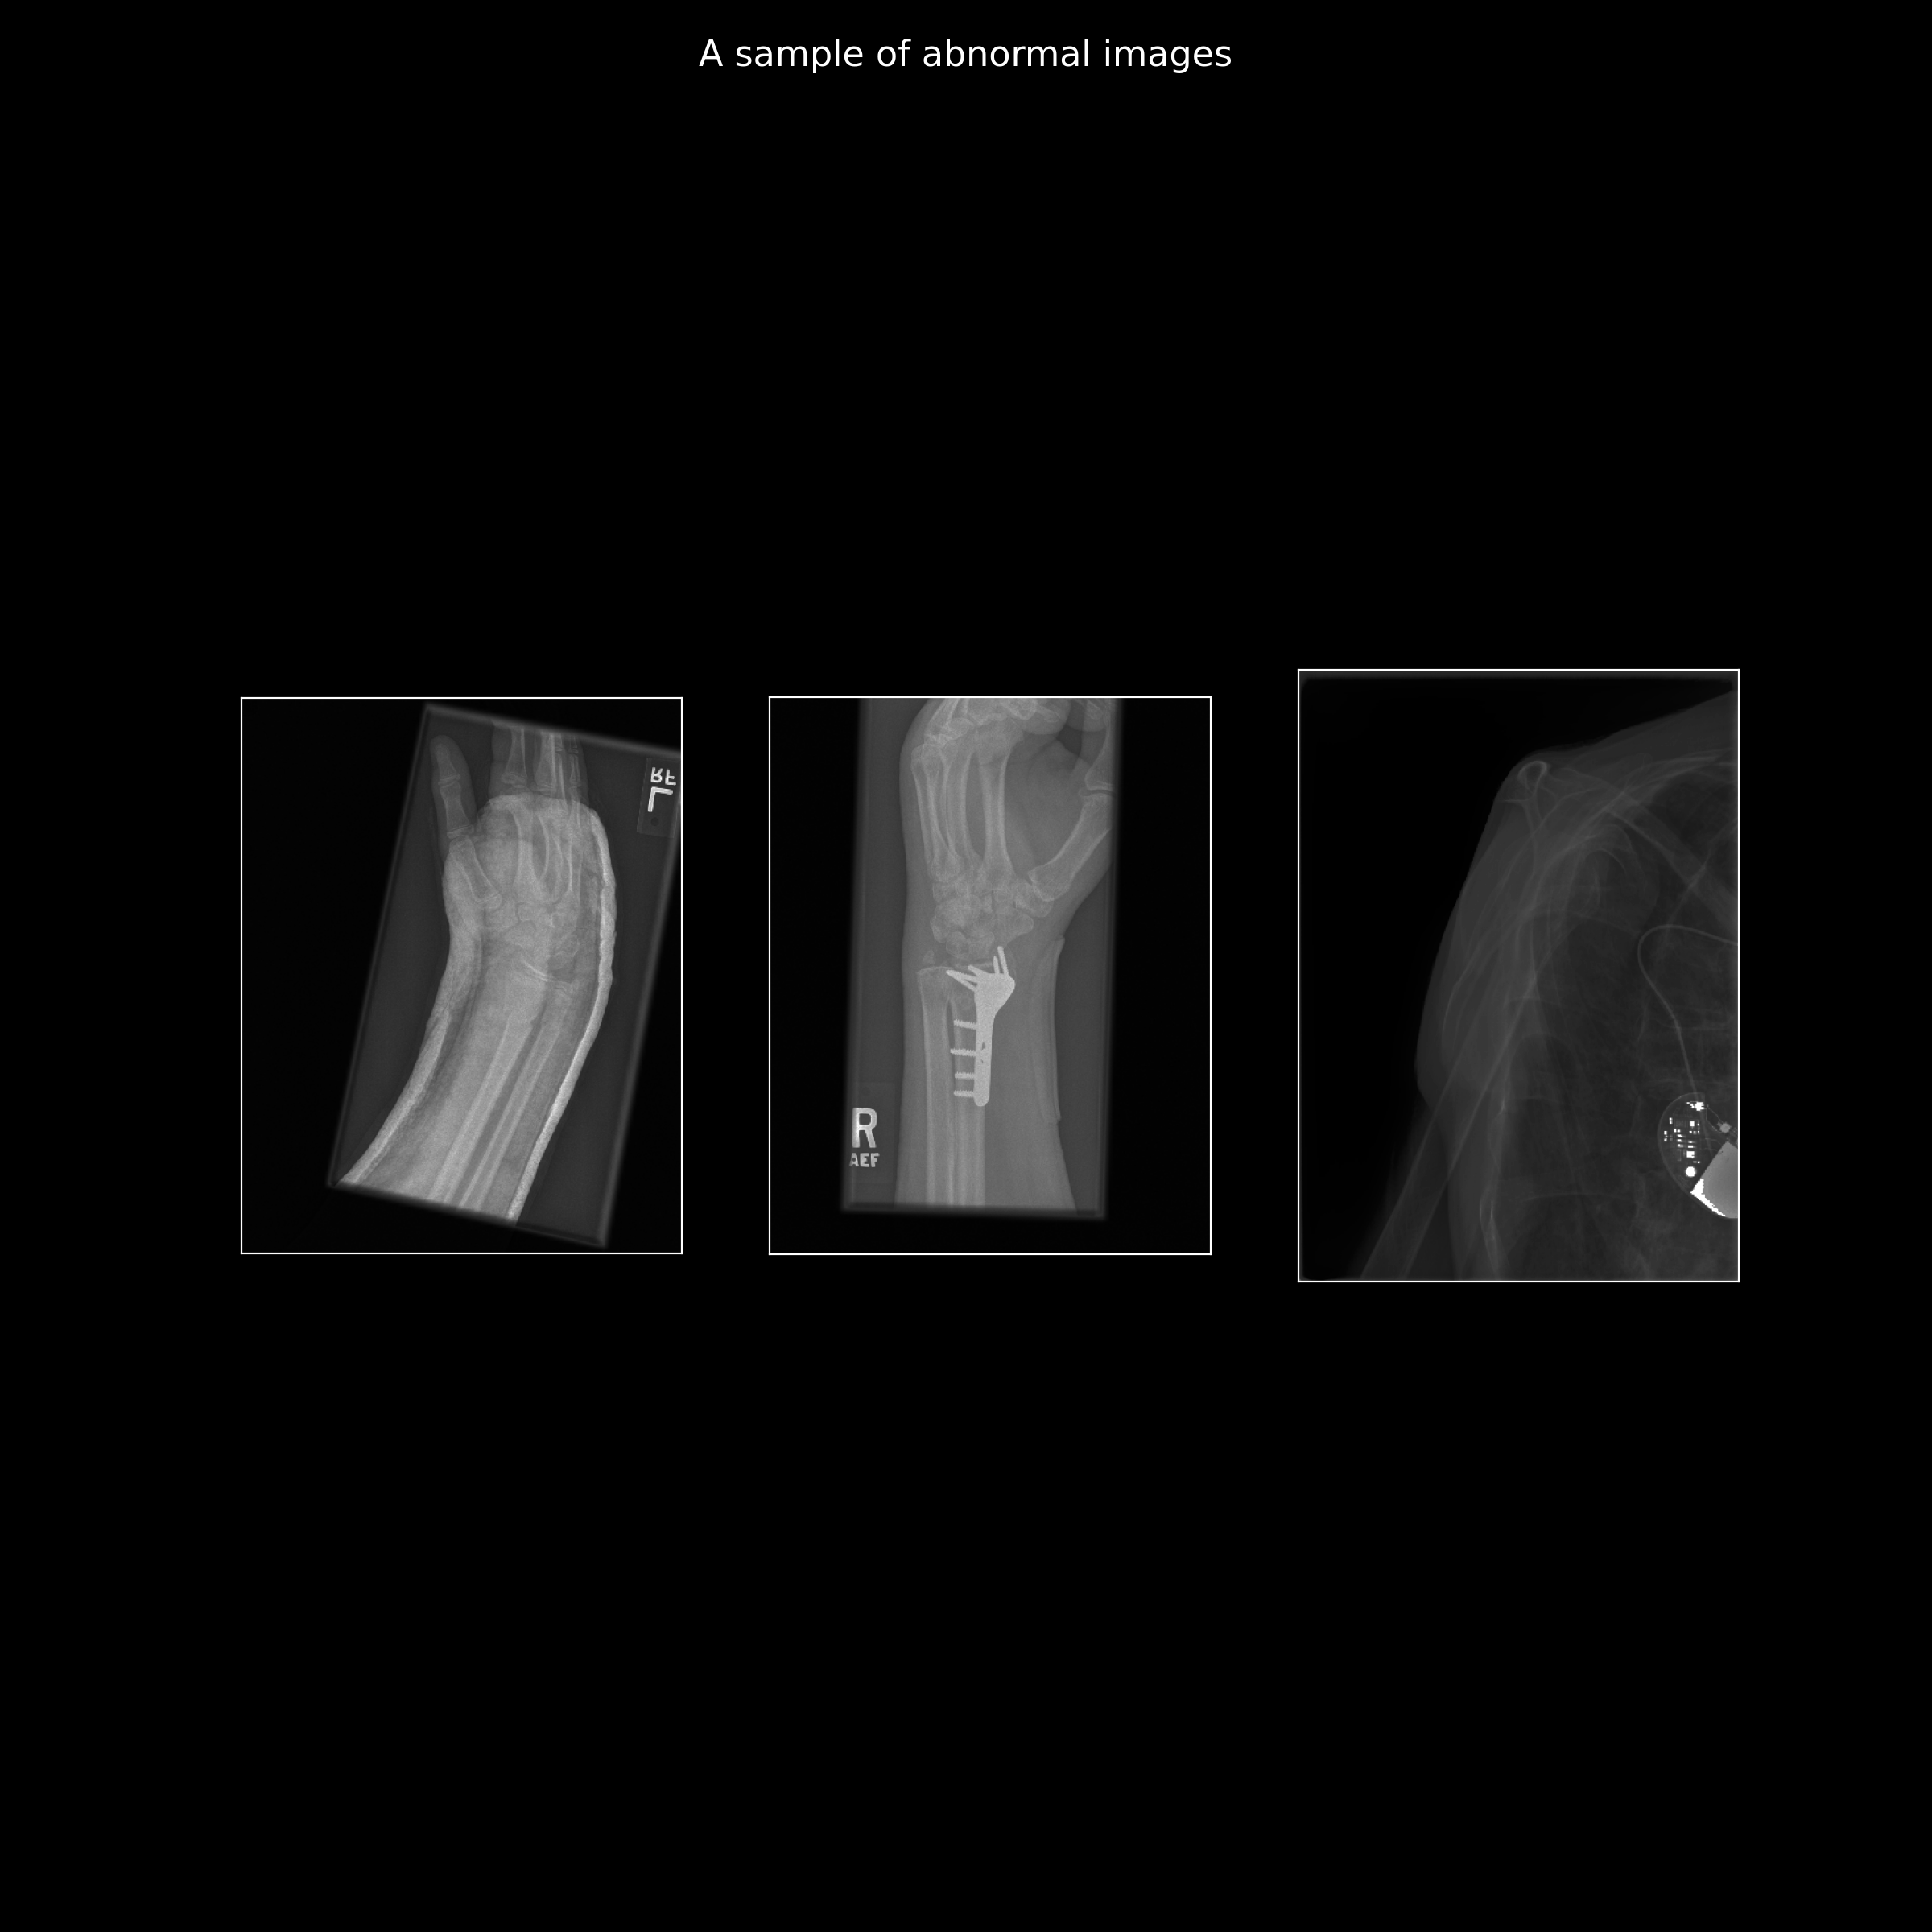

In [17]:
ax = []
fig = plt.figure(figsize=(12, 12))
fig.suptitle("A sample of abnormal images", fontsize=16)
positive_sample = (
    ref_trainset[ref_trainset["image_path"].str.contains("positive")]["image_path"]
    .sample(3, random_state=SEED)
    .values
)

for ix, path in enumerate(positive_sample):
    img = image.imread(path)
    ax.append(fig.add_subplot(1, 3, ix + 1))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap="gray")
plt.show()

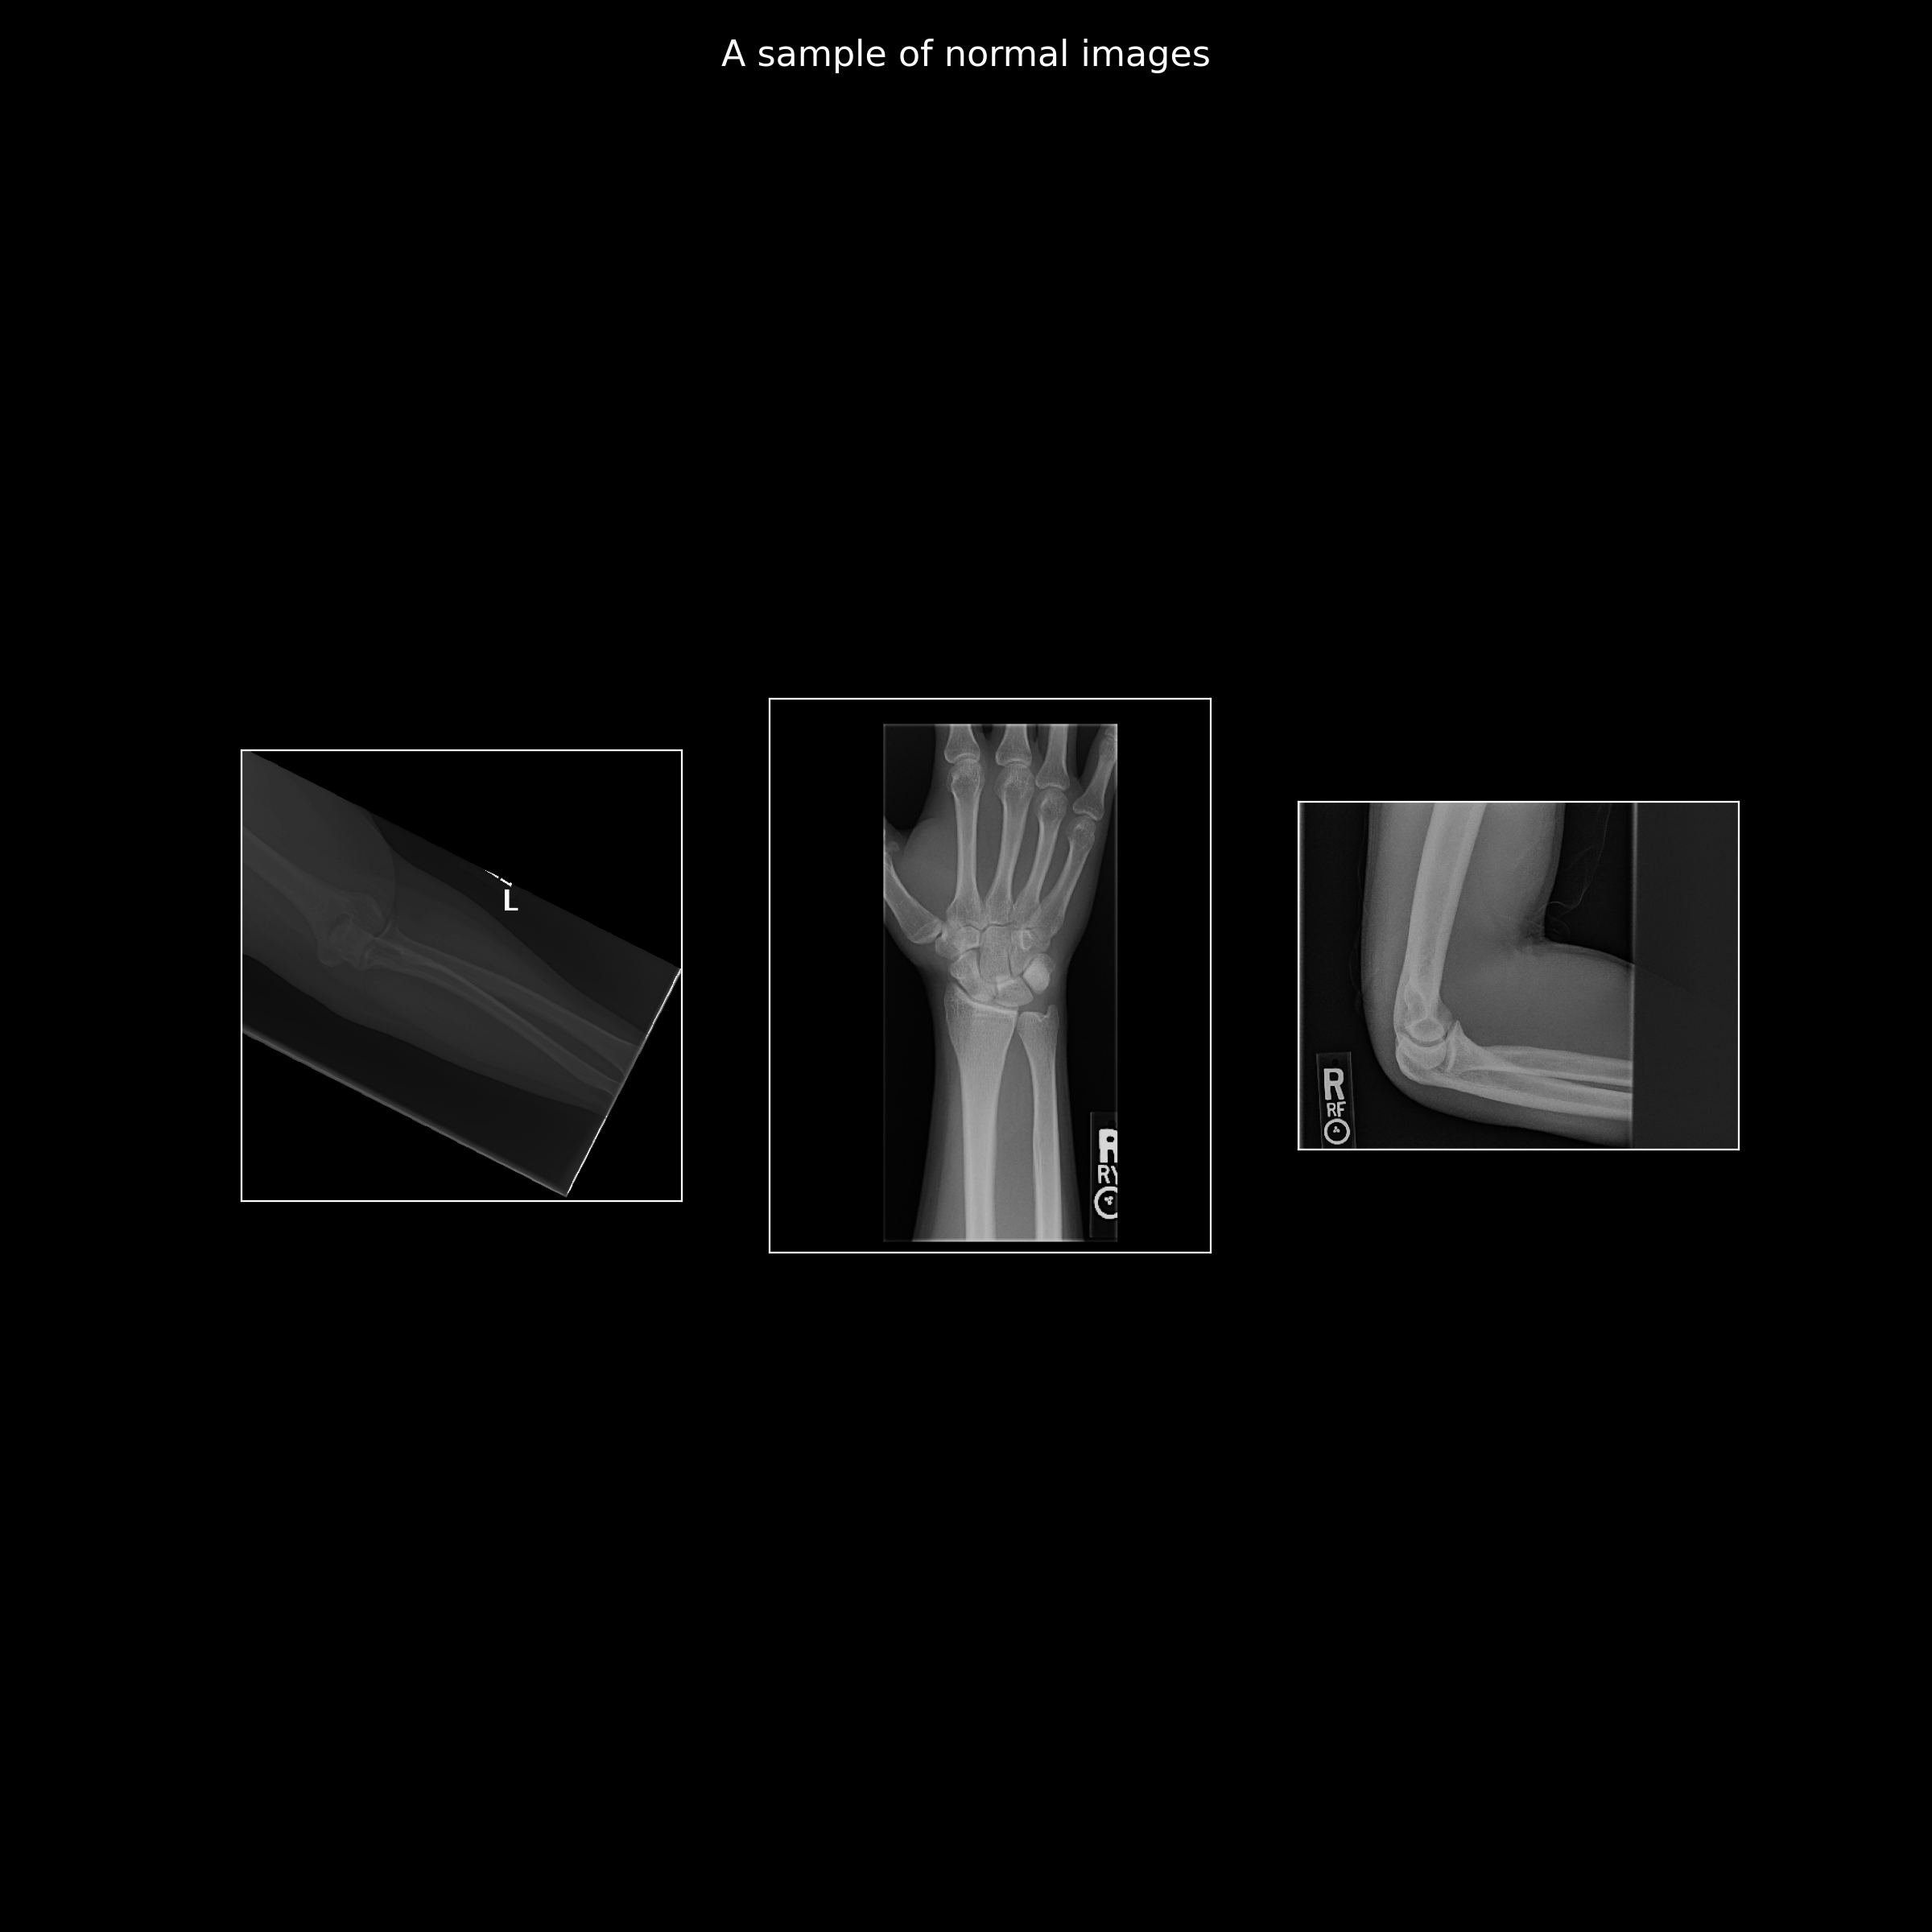

In [53]:
ax = []
fig = plt.figure(figsize=(12, 12))
fig.suptitle("A sample of normal images", fontsize=16)
negative_sample = (
    ref_trainset[ref_trainset["image_path"].str.contains("negative")]["image_path"]
    .sample(3, random_state=SEED)
    .values
)

for ix, path in enumerate(negative_sample):
    img = image.imread(path)
    ax.append(fig.add_subplot(1, 3, ix + 1))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap="gray")
plt.show()

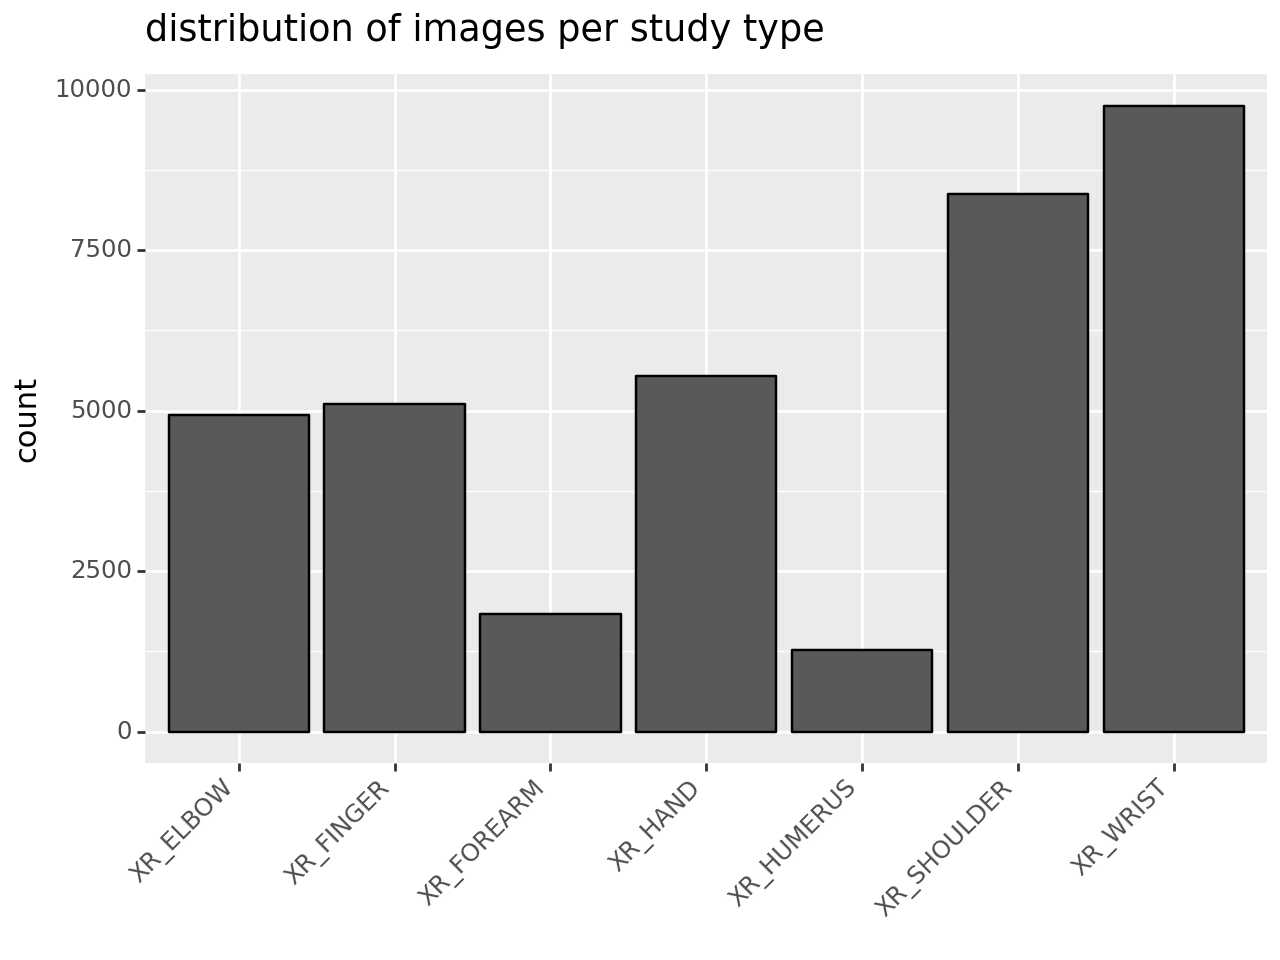

<Figure Size: (640 x 480)>

In [33]:
(
    ggplot(ref_trainset)
    + geom_bar(aes(x="study_type"), colour="black")
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    + labs(x="", y="count", title="distribution of images per study type")
)

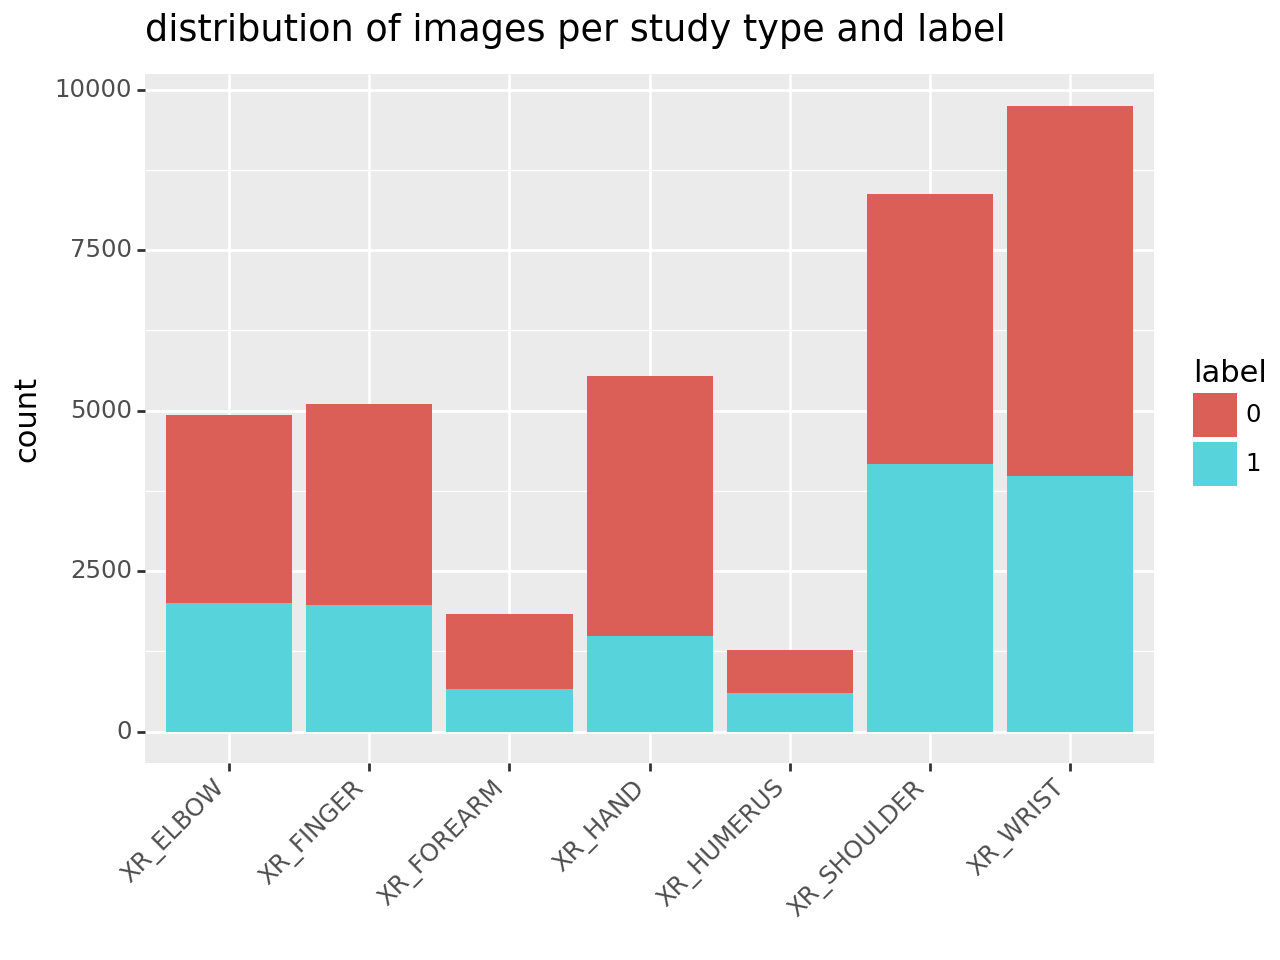

<Figure Size: (640 x 480)>

In [41]:
(
    ggplot(ref_trainset)
    + geom_bar(aes(x="study_type", fill="label"))
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    + labs(x="", y="count", title="distribution of images per study type and label")
)

In [43]:
classes = ref_trainset["study_type"].unique()

for klass in classes:

    majority, minority = (
        ref_trainset.groupby(["study_type", "label"])["study_type"].count().loc[(klass)]
    )
    #print(klass,"   :   ",majority,"   :   ",minority)

    print(
        f"study type: {klass + ' ' * (11 - len(klass))}  |  imbalance ratio: {round(minority / majority, 3)}"
    )

study type: XR_SHOULDER  |  imbalance ratio: 0.99
study type: XR_HUMERUS   |  imbalance ratio: 0.89
study type: XR_FINGER    |  imbalance ratio: 0.627
study type: XR_ELBOW     |  imbalance ratio: 0.686
study type: XR_WRIST     |  imbalance ratio: 0.692
study type: XR_FOREARM   |  imbalance ratio: 0.568
study type: XR_HAND      |  imbalance ratio: 0.366


We can observe that the `XR_SHOULDER` study type is a balanced "sub-dataset" w.r.t abnormality.

The other study types exhibit different ratios of imbalance, with the most imbalance type being `XR_HAND`.

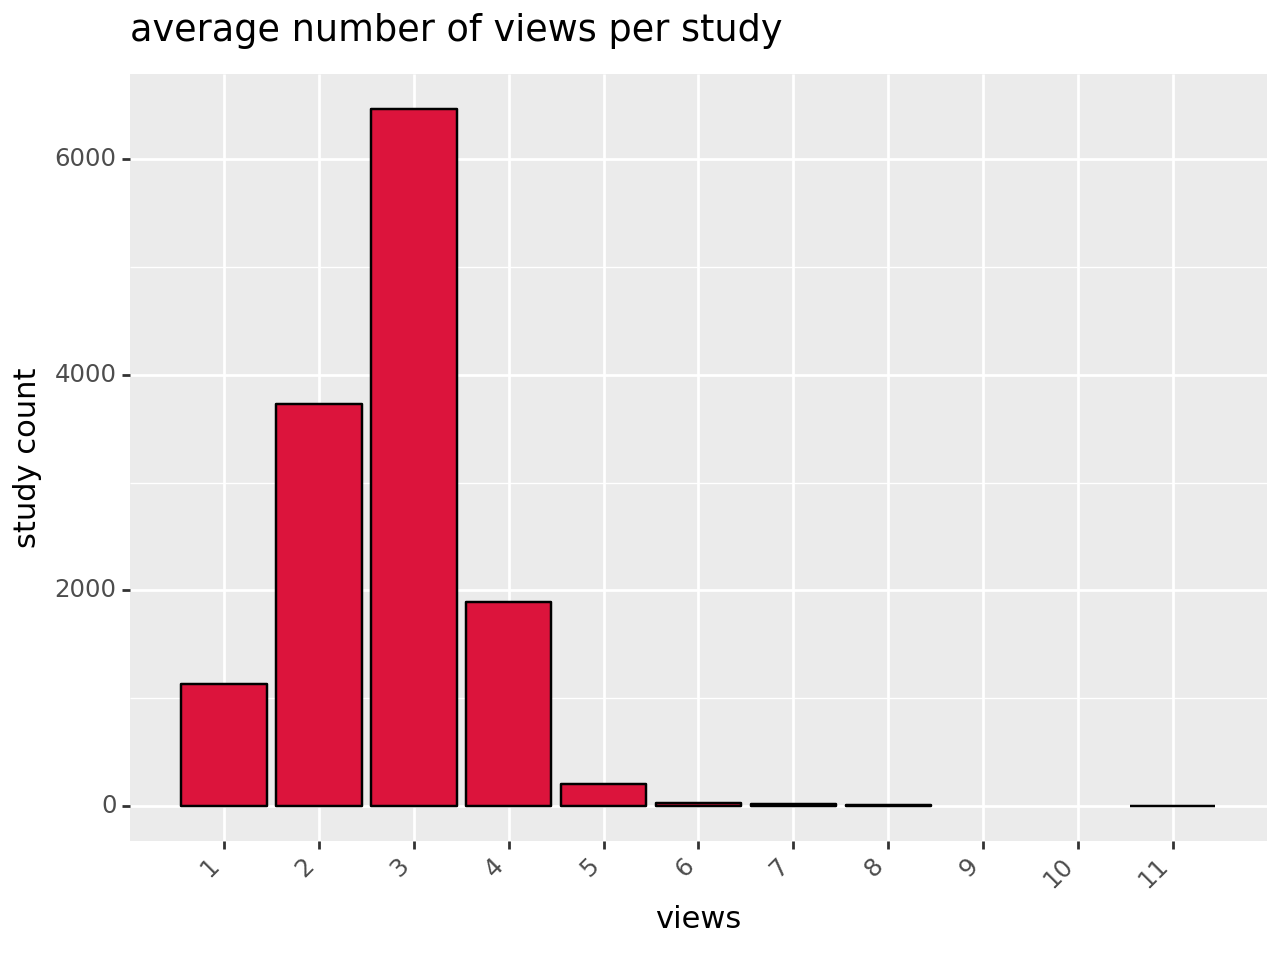

<Figure Size: (640 x 480)>

In [24]:
(
    ggplot(ref_trainset.groupby("study_path").count())
    + geom_bar(aes(x="study_type"), colour="black", fill="crimson")
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    + scale_x_continuous(breaks=range(0, 12), minor_breaks=[])
    + labs(x="views", y="study count", title="average number of views per study")
)

We can also see that the majority of the studies have 2 or 3 views. An outlier study also exists, with >10 views.